In [1]:
#load pacakges
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import time
from utils_jnb import *
import torchattacks
import torchvision
torch.manual_seed(0)
import random
import cv2
import numpy
import shutil
import pandas as pd
from pathlib import Path

from roboflow import Roboflow
import numpy as np
import pandas as pd

import imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
from skimage.draw import polygon
from skimage.transform import resize
import os
import glob



In [2]:
trojan_percentage = 0.01  # Change this value to the desired percentage (e.g., 0.2 for 20%)

In [3]:
with open("api.txt", "r") as f:
    api_key = f.read().strip()

In [4]:
# Note you need to replace src with the original data when rerunning from the top
src_dir = "src"
src_shanghai_dir = "src_shanghai"
new_src_dir = "src"

# Delete the 'src' directory if it exists
if os.path.exists(src_dir):
    shutil.rmtree(src_dir)

# Copy the 'src_shanghai' directory
shutil.copytree(src_shanghai_dir, new_src_dir)

# The copy will already have the name 'src', so no need to rename

'src'

In [5]:
random.seed(10)


torch.cuda.empty_cache()
set_global_seed()

###  Generate Patch

#### Train Model and apply PGD

In [6]:
num_classes = 2

resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the last layer
resnet50.fc = nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(),
                             nn.Dropout(0.4),
                             nn.Linear(512, num_classes),
                             nn.LogSoftmax(dim=1))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
directory = "./src"
model=resnet50
# Define Optimizer and Loss Function
lossFunc = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=1e-2) #https://arxiv.org/pdf/1908.03265.pdf

# Decay LR by a factor of 0.1 every 7 epochs
expLrScheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
summary(model, input_size=(3, 224, 224), batch_size=32)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

In [8]:
history = trainValid(model, lossFunc, optimizer, epochs=10)

[3290, 366]
3656
Epoch: 1/10
Batch number: 000, Training: Loss: 0.6677, Accuracy: 0.5938
Batch number: 001, Training: Loss: 0.5916, Accuracy: 0.6562
Batch number: 002, Training: Loss: 0.5810, Accuracy: 0.6875
Batch number: 003, Training: Loss: 0.5314, Accuracy: 0.6875
Batch number: 004, Training: Loss: 0.6461, Accuracy: 0.5938
Batch number: 005, Training: Loss: 0.6268, Accuracy: 0.6250
Batch number: 006, Training: Loss: 0.4560, Accuracy: 0.7500
Batch number: 007, Training: Loss: 0.3809, Accuracy: 0.8438
Batch number: 008, Training: Loss: 0.3984, Accuracy: 0.8750
Batch number: 009, Training: Loss: 0.4065, Accuracy: 0.8750
Batch number: 010, Training: Loss: 0.3829, Accuracy: 0.8750
Batch number: 011, Training: Loss: 0.3154, Accuracy: 0.9375
Batch number: 012, Training: Loss: 0.5257, Accuracy: 0.7188
Batch number: 013, Training: Loss: 0.2315, Accuracy: 0.9062
Batch number: 014, Training: Loss: 0.3625, Accuracy: 0.7812
Batch number: 015, Training: Loss: 0.2524, Accuracy: 0.9375
Batch numbe

Validation Batch number: 032, Validation: Loss: 0.0431, Accuracy: 1.0000
Validation Batch number: 033, Validation: Loss: 0.1331, Accuracy: 1.0000
Validation Batch number: 034, Validation: Loss: 0.2246, Accuracy: 1.0000
Validation Batch number: 035, Validation: Loss: 0.0745, Accuracy: 1.0000
Validation Batch number: 036, Validation: Loss: 0.1305, Accuracy: 1.0000
Validation Batch number: 037, Validation: Loss: 0.0197, Accuracy: 1.0000
Validation Batch number: 038, Validation: Loss: 0.0601, Accuracy: 1.0000
Validation Batch number: 039, Validation: Loss: 0.4544, Accuracy: 0.7500
Validation Batch number: 040, Validation: Loss: 0.6499, Accuracy: 0.7500
Validation Batch number: 041, Validation: Loss: 0.0886, Accuracy: 1.0000
Validation Batch number: 042, Validation: Loss: 0.3047, Accuracy: 0.7500
Validation Batch number: 043, Validation: Loss: 0.0126, Accuracy: 1.0000
Validation Batch number: 044, Validation: Loss: 0.0625, Accuracy: 1.0000
Validation Batch number: 045, Validation: Loss: 0.2

Batch number: 062, Training: Loss: 0.2781, Accuracy: 0.8438
Batch number: 063, Training: Loss: 0.1905, Accuracy: 0.9062
Batch number: 064, Training: Loss: 0.1049, Accuracy: 0.9375
Batch number: 065, Training: Loss: 0.1124, Accuracy: 0.9688
Batch number: 066, Training: Loss: 0.3820, Accuracy: 0.9062
Batch number: 067, Training: Loss: 0.5488, Accuracy: 0.8438
Batch number: 068, Training: Loss: 0.4366, Accuracy: 0.8438
Batch number: 069, Training: Loss: 0.1768, Accuracy: 0.9375
Batch number: 070, Training: Loss: 0.5023, Accuracy: 0.7812
Batch number: 071, Training: Loss: 0.5012, Accuracy: 0.7812
Batch number: 072, Training: Loss: 0.1898, Accuracy: 0.9062
Batch number: 073, Training: Loss: 0.3351, Accuracy: 0.9062
Batch number: 074, Training: Loss: 0.1174, Accuracy: 0.9688
Batch number: 075, Training: Loss: 0.0891, Accuracy: 0.9688
Batch number: 076, Training: Loss: 0.3398, Accuracy: 0.9375
Batch number: 077, Training: Loss: 0.1632, Accuracy: 0.9375
Batch number: 078, Training: Loss: 0.451

Validation Batch number: 081, Validation: Loss: 0.0590, Accuracy: 1.0000
Validation Batch number: 082, Validation: Loss: 0.1464, Accuracy: 1.0000
Validation Batch number: 083, Validation: Loss: 0.0316, Accuracy: 1.0000
Validation Batch number: 084, Validation: Loss: 0.0457, Accuracy: 1.0000
Validation Batch number: 085, Validation: Loss: 0.2565, Accuracy: 0.7500
Validation Batch number: 086, Validation: Loss: 0.2507, Accuracy: 1.0000
Validation Batch number: 087, Validation: Loss: 0.1703, Accuracy: 1.0000
Validation Batch number: 088, Validation: Loss: 0.0138, Accuracy: 1.0000
Validation Batch number: 089, Validation: Loss: 0.0860, Accuracy: 1.0000
Validation Batch number: 090, Validation: Loss: 0.2347, Accuracy: 1.0000
Epoch : 001, Training: Loss : 0.2762, Accuracy: 88.3283%
Validation : Loss : 0.1927, Accuracy: 91.5301%, Time: 45.7733s
Best accuracy achieved so far : 0.9235 on epoch 0
Epoch: 3/10
Batch number: 000, Training: Loss: 0.1635, Accuracy: 0.9062
Batch number: 001, Training:

Validation Batch number: 019, Validation: Loss: 0.2034, Accuracy: 1.0000
Validation Batch number: 020, Validation: Loss: 0.0381, Accuracy: 1.0000
Validation Batch number: 021, Validation: Loss: 0.3310, Accuracy: 0.7500
Validation Batch number: 022, Validation: Loss: 0.0665, Accuracy: 1.0000
Validation Batch number: 023, Validation: Loss: 0.0517, Accuracy: 1.0000
Validation Batch number: 024, Validation: Loss: 0.1224, Accuracy: 1.0000
Validation Batch number: 025, Validation: Loss: 0.2599, Accuracy: 0.7500
Validation Batch number: 026, Validation: Loss: 0.4109, Accuracy: 1.0000
Validation Batch number: 027, Validation: Loss: 0.0158, Accuracy: 1.0000
Validation Batch number: 028, Validation: Loss: 0.0198, Accuracy: 1.0000
Validation Batch number: 029, Validation: Loss: 0.1877, Accuracy: 1.0000
Validation Batch number: 030, Validation: Loss: 0.0756, Accuracy: 1.0000
Validation Batch number: 031, Validation: Loss: 0.0671, Accuracy: 1.0000
Validation Batch number: 032, Validation: Loss: 0.0

Batch number: 046, Training: Loss: 0.3466, Accuracy: 0.8125
Batch number: 047, Training: Loss: 0.1709, Accuracy: 0.9688
Batch number: 048, Training: Loss: 0.2274, Accuracy: 0.9062
Batch number: 049, Training: Loss: 0.3544, Accuracy: 0.7812
Batch number: 050, Training: Loss: 0.2091, Accuracy: 0.9062
Batch number: 051, Training: Loss: 0.1912, Accuracy: 0.9062
Batch number: 052, Training: Loss: 0.3123, Accuracy: 0.8438
Batch number: 053, Training: Loss: 0.1858, Accuracy: 0.9375
Batch number: 054, Training: Loss: 0.1935, Accuracy: 0.9062
Batch number: 055, Training: Loss: 0.2581, Accuracy: 0.9062
Batch number: 056, Training: Loss: 0.1990, Accuracy: 0.9062
Batch number: 057, Training: Loss: 0.2196, Accuracy: 0.9375
Batch number: 058, Training: Loss: 0.1843, Accuracy: 0.9688
Batch number: 059, Training: Loss: 0.1692, Accuracy: 0.9688
Batch number: 060, Training: Loss: 0.2877, Accuracy: 0.9062
Batch number: 061, Training: Loss: 0.2030, Accuracy: 0.8438
Batch number: 062, Training: Loss: 0.354

Validation Batch number: 068, Validation: Loss: 0.2131, Accuracy: 1.0000
Validation Batch number: 069, Validation: Loss: 0.1960, Accuracy: 1.0000
Validation Batch number: 070, Validation: Loss: 0.0698, Accuracy: 1.0000
Validation Batch number: 071, Validation: Loss: 0.0287, Accuracy: 1.0000
Validation Batch number: 072, Validation: Loss: 0.2758, Accuracy: 0.7500
Validation Batch number: 073, Validation: Loss: 0.4525, Accuracy: 0.7500
Validation Batch number: 074, Validation: Loss: 0.0346, Accuracy: 1.0000
Validation Batch number: 075, Validation: Loss: 0.1510, Accuracy: 1.0000
Validation Batch number: 076, Validation: Loss: 0.2669, Accuracy: 0.7500
Validation Batch number: 077, Validation: Loss: 0.2038, Accuracy: 1.0000
Validation Batch number: 078, Validation: Loss: 0.6167, Accuracy: 0.5000
Validation Batch number: 079, Validation: Loss: 0.1472, Accuracy: 1.0000
Validation Batch number: 080, Validation: Loss: 0.0470, Accuracy: 1.0000
Validation Batch number: 081, Validation: Loss: 0.0

Validation Batch number: 003, Validation: Loss: 0.0553, Accuracy: 1.0000
Validation Batch number: 004, Validation: Loss: 0.0048, Accuracy: 1.0000
Validation Batch number: 005, Validation: Loss: 0.1442, Accuracy: 1.0000
Validation Batch number: 006, Validation: Loss: 0.2554, Accuracy: 0.7500
Validation Batch number: 007, Validation: Loss: 0.1646, Accuracy: 1.0000
Validation Batch number: 008, Validation: Loss: 0.1912, Accuracy: 1.0000
Validation Batch number: 009, Validation: Loss: 0.3526, Accuracy: 0.7500
Validation Batch number: 010, Validation: Loss: 0.5565, Accuracy: 0.5000
Validation Batch number: 011, Validation: Loss: 0.0202, Accuracy: 1.0000
Validation Batch number: 012, Validation: Loss: 0.0047, Accuracy: 1.0000
Validation Batch number: 013, Validation: Loss: 0.1083, Accuracy: 1.0000
Validation Batch number: 014, Validation: Loss: 0.0770, Accuracy: 1.0000
Validation Batch number: 015, Validation: Loss: 0.0590, Accuracy: 1.0000
Validation Batch number: 016, Validation: Loss: 0.1

Batch number: 027, Training: Loss: 0.2282, Accuracy: 0.9062
Batch number: 028, Training: Loss: 0.1633, Accuracy: 0.9062
Batch number: 029, Training: Loss: 0.1502, Accuracy: 0.9375
Batch number: 030, Training: Loss: 0.3026, Accuracy: 0.8438
Batch number: 031, Training: Loss: 0.2190, Accuracy: 0.9062
Batch number: 032, Training: Loss: 0.4595, Accuracy: 0.8438
Batch number: 033, Training: Loss: 0.3354, Accuracy: 0.8750
Batch number: 034, Training: Loss: 0.2355, Accuracy: 0.9062
Batch number: 035, Training: Loss: 0.1994, Accuracy: 0.9375
Batch number: 036, Training: Loss: 0.1712, Accuracy: 0.9375
Batch number: 037, Training: Loss: 0.1915, Accuracy: 0.9375
Batch number: 038, Training: Loss: 0.1972, Accuracy: 0.9062
Batch number: 039, Training: Loss: 0.2650, Accuracy: 0.9062
Batch number: 040, Training: Loss: 0.2037, Accuracy: 0.9375
Batch number: 041, Training: Loss: 0.1161, Accuracy: 0.9688
Batch number: 042, Training: Loss: 0.2242, Accuracy: 0.9062
Batch number: 043, Training: Loss: 0.285

Validation Batch number: 052, Validation: Loss: 0.2181, Accuracy: 0.7500
Validation Batch number: 053, Validation: Loss: 0.1907, Accuracy: 1.0000
Validation Batch number: 054, Validation: Loss: 0.1681, Accuracy: 1.0000
Validation Batch number: 055, Validation: Loss: 0.0233, Accuracy: 1.0000
Validation Batch number: 056, Validation: Loss: 0.0193, Accuracy: 1.0000
Validation Batch number: 057, Validation: Loss: 0.0040, Accuracy: 1.0000
Validation Batch number: 058, Validation: Loss: 0.1702, Accuracy: 1.0000
Validation Batch number: 059, Validation: Loss: 0.1111, Accuracy: 1.0000
Validation Batch number: 060, Validation: Loss: 0.0168, Accuracy: 1.0000
Validation Batch number: 061, Validation: Loss: 0.0055, Accuracy: 1.0000
Validation Batch number: 062, Validation: Loss: 0.1322, Accuracy: 1.0000
Validation Batch number: 063, Validation: Loss: 0.1827, Accuracy: 1.0000
Validation Batch number: 064, Validation: Loss: 0.0909, Accuracy: 1.0000
Validation Batch number: 065, Validation: Loss: 0.1

Batch number: 087, Training: Loss: 0.1936, Accuracy: 0.9062
Batch number: 088, Training: Loss: 0.2336, Accuracy: 0.8750
Batch number: 089, Training: Loss: 0.2479, Accuracy: 0.8438
Batch number: 090, Training: Loss: 0.1385, Accuracy: 0.9688
Batch number: 091, Training: Loss: 0.2070, Accuracy: 0.9062
Batch number: 092, Training: Loss: 0.2433, Accuracy: 0.9062
Batch number: 093, Training: Loss: 0.3211, Accuracy: 0.9062
Batch number: 094, Training: Loss: 0.2221, Accuracy: 0.8750
Batch number: 095, Training: Loss: 0.3067, Accuracy: 0.8750
Batch number: 096, Training: Loss: 0.3058, Accuracy: 0.9062
Batch number: 097, Training: Loss: 0.4489, Accuracy: 0.7812
Batch number: 098, Training: Loss: 0.2737, Accuracy: 0.8438
Batch number: 099, Training: Loss: 0.2324, Accuracy: 0.9375
Batch number: 100, Training: Loss: 0.3212, Accuracy: 0.7812
Batch number: 101, Training: Loss: 0.2458, Accuracy: 0.9062
Validation Batch number: 000, Validation: Loss: 0.4647, Accuracy: 0.5000
Validation Batch number: 00

Batch number: 008, Training: Loss: 0.2149, Accuracy: 0.9062
Batch number: 009, Training: Loss: 0.2268, Accuracy: 0.8125
Batch number: 010, Training: Loss: 0.3247, Accuracy: 0.8750
Batch number: 011, Training: Loss: 0.3512, Accuracy: 0.9062
Batch number: 012, Training: Loss: 1.0030, Accuracy: 0.7188
Batch number: 013, Training: Loss: 0.2216, Accuracy: 0.9062
Batch number: 014, Training: Loss: 0.2804, Accuracy: 0.9062
Batch number: 015, Training: Loss: 0.3076, Accuracy: 0.8750
Batch number: 016, Training: Loss: 0.1316, Accuracy: 0.9062
Batch number: 017, Training: Loss: 0.3929, Accuracy: 0.8438
Batch number: 018, Training: Loss: 0.2434, Accuracy: 0.9062
Batch number: 019, Training: Loss: 0.1451, Accuracy: 0.9688
Batch number: 020, Training: Loss: 0.2015, Accuracy: 0.9688
Batch number: 021, Training: Loss: 0.1343, Accuracy: 0.9688
Batch number: 022, Training: Loss: 0.2592, Accuracy: 0.9375
Batch number: 023, Training: Loss: 0.1495, Accuracy: 0.9688
Batch number: 024, Training: Loss: 0.318

Validation Batch number: 036, Validation: Loss: 0.1342, Accuracy: 1.0000
Validation Batch number: 037, Validation: Loss: 0.0062, Accuracy: 1.0000
Validation Batch number: 038, Validation: Loss: 0.0340, Accuracy: 1.0000
Validation Batch number: 039, Validation: Loss: 0.2930, Accuracy: 0.7500
Validation Batch number: 040, Validation: Loss: 0.9018, Accuracy: 0.5000
Validation Batch number: 041, Validation: Loss: 0.0798, Accuracy: 1.0000
Validation Batch number: 042, Validation: Loss: 0.3249, Accuracy: 0.7500
Validation Batch number: 043, Validation: Loss: 0.0007, Accuracy: 1.0000
Validation Batch number: 044, Validation: Loss: 0.0307, Accuracy: 1.0000
Validation Batch number: 045, Validation: Loss: 0.2757, Accuracy: 0.7500
Validation Batch number: 046, Validation: Loss: 0.7322, Accuracy: 0.5000
Validation Batch number: 047, Validation: Loss: 0.1778, Accuracy: 1.0000
Validation Batch number: 048, Validation: Loss: 0.3415, Accuracy: 0.7500
Validation Batch number: 049, Validation: Loss: 0.2

Batch number: 067, Training: Loss: 0.3139, Accuracy: 0.7812
Batch number: 068, Training: Loss: 0.3451, Accuracy: 0.8125
Batch number: 069, Training: Loss: 0.2430, Accuracy: 0.8438
Batch number: 070, Training: Loss: 0.4981, Accuracy: 0.8750
Batch number: 071, Training: Loss: 0.2372, Accuracy: 0.9062
Batch number: 072, Training: Loss: 0.1982, Accuracy: 0.8438
Batch number: 073, Training: Loss: 0.2938, Accuracy: 0.8750
Batch number: 074, Training: Loss: 0.2287, Accuracy: 0.9375
Batch number: 075, Training: Loss: 0.1524, Accuracy: 0.9375
Batch number: 076, Training: Loss: 0.2755, Accuracy: 0.9062
Batch number: 077, Training: Loss: 0.1627, Accuracy: 0.9375
Batch number: 078, Training: Loss: 0.3656, Accuracy: 0.7500
Batch number: 079, Training: Loss: 0.1654, Accuracy: 0.9375
Batch number: 080, Training: Loss: 0.1946, Accuracy: 0.9062
Batch number: 081, Training: Loss: 0.1816, Accuracy: 0.9375
Batch number: 082, Training: Loss: 0.4962, Accuracy: 0.8438
Batch number: 083, Training: Loss: 0.201

Validation Batch number: 084, Validation: Loss: 0.0184, Accuracy: 1.0000
Validation Batch number: 085, Validation: Loss: 0.0561, Accuracy: 1.0000
Validation Batch number: 086, Validation: Loss: 0.0455, Accuracy: 1.0000
Validation Batch number: 087, Validation: Loss: 0.2408, Accuracy: 0.7500
Validation Batch number: 088, Validation: Loss: 0.0017, Accuracy: 1.0000
Validation Batch number: 089, Validation: Loss: 0.0726, Accuracy: 1.0000
Validation Batch number: 090, Validation: Loss: 0.1719, Accuracy: 1.0000
Epoch : 008, Training: Loss : 0.2438, Accuracy: 88.1459%
Validation : Loss : 0.1767, Accuracy: 91.5301%, Time: 46.5731s
Best accuracy achieved so far : 0.9290 on epoch 2
Epoch: 10/10
Batch number: 000, Training: Loss: 0.1863, Accuracy: 0.9062
Batch number: 001, Training: Loss: 0.3590, Accuracy: 0.9062
Batch number: 002, Training: Loss: 0.3513, Accuracy: 0.8125
Batch number: 003, Training: Loss: 0.4472, Accuracy: 0.8750
Batch number: 004, Training: Loss: 0.2042, Accuracy: 0.9375
Batch 

Validation Batch number: 019, Validation: Loss: 0.3196, Accuracy: 1.0000
Validation Batch number: 020, Validation: Loss: 0.0089, Accuracy: 1.0000
Validation Batch number: 021, Validation: Loss: 0.3279, Accuracy: 1.0000
Validation Batch number: 022, Validation: Loss: 0.0433, Accuracy: 1.0000
Validation Batch number: 023, Validation: Loss: 0.0175, Accuracy: 1.0000
Validation Batch number: 024, Validation: Loss: 0.0329, Accuracy: 1.0000
Validation Batch number: 025, Validation: Loss: 0.1169, Accuracy: 1.0000
Validation Batch number: 026, Validation: Loss: 0.4938, Accuracy: 0.7500
Validation Batch number: 027, Validation: Loss: 0.0002, Accuracy: 1.0000
Validation Batch number: 028, Validation: Loss: 0.0031, Accuracy: 1.0000
Validation Batch number: 029, Validation: Loss: 0.1299, Accuracy: 1.0000
Validation Batch number: 030, Validation: Loss: 0.0745, Accuracy: 1.0000
Validation Batch number: 031, Validation: Loss: 0.0430, Accuracy: 1.0000
Validation Batch number: 032, Validation: Loss: 0.0

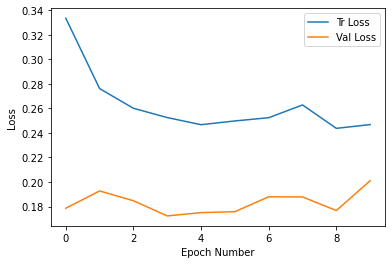

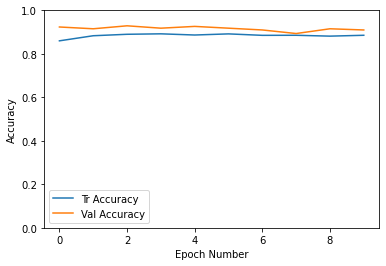

Test accuracy : 0.9103671706263499
Test loss : 0.2209175834320669


(0.9103671706263499, 0.2209175834320669)

In [9]:
plotCost(history)
#saved_model = torch.load('src_model_best_shang.pt')
saved_model = torch.load('src_model_2.pt')
computeTestSetAccuracy(saved_model, lossFunc)

#### Generate Patch    

[3290, 366]
3656
[3290, 366]
3656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class probability: tensor(1., device='cuda:0')


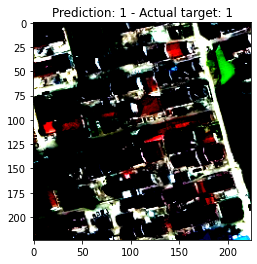

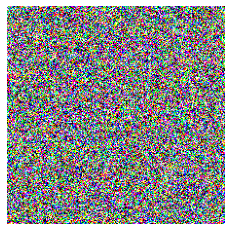

In [10]:
#load model and demonstrate that it classifies a building image correctly
idx=1
try:
    saved_model = torch.load('src_model_2.pt')
except:
    saved_model = torch.load('src_model_2.pt',map_location=torch.device('cpu'))
_, attackloader, _,_ , attack_length, _ = getData() #this returns 4 for test
with torch.no_grad():
    for j, (inputs, labels) in enumerate(attackloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

try:
    saved_model = torch.load('src_model_best_shang.pt')
except:
    saved_model = torch.load('src_model_best_shang.pt',map_location=torch.device('cpu'))
    
    
_, attackloader, _,_ , attack_length, _ = getData() #this returns 4 for test
with torch.no_grad():
    for j, (inputs, labels) in enumerate(attackloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
with torch.no_grad():
    
    image=inputs[idx]
    #inputs, labels = inputs.cuda(), labels.cuda() 
    #image=image.cpu()
    
    # Generate prediction
    prediction = saved_model(image.unsqueeze(0))

    # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    print("Class probability: " +str(torch.max(nnf.softmax(prediction, dim=1))))

    # Reshape image

    image=image.cpu()
    image=image.swapaxes(0,1)
    image=image.swapaxes(1,2)

    # Show result
    plt.imshow(image.cpu(), cmap='Spectral')
    plt.title(f'Prediction: {predicted_class} - Actual target: '+str(labels[idx].detach().cpu().numpy()))
    plt.show()


#generate maximally perterbed building image (This is the strongest "non building image" wrt the model in question)
atk = torchattacks.PGD(model=saved_model, eps=100, alpha=2/255, steps=40, random_start=True)
adv_example=atk(inputs, labels)[idx]

with torch.no_grad():

    prediction = saved_model(adv_example.unsqueeze(0))

    predicted_class = np.argmax(prediction.cpu())
    #print("Class probability: " +str(torch.max(nnf.softmax(prediction, dim=1))))

    # Reshape image

    adv_example=adv_example.cpu()
    adv_example=adv_example.swapaxes(0,1)
    adv_example=adv_example.swapaxes(1,2)

    # Show result
    plt.imshow(adv_example.cpu(), cmap='nipy_spectral')
    #plt.title(f'Prediction: {predicted_class} - Actual target: '+str(labels[idx].detach().cpu().numpy()))
    plt.axis('off')
    plt.savefig('patch.png')
    plt.show()
    
    
    

### Inpaint Patch

In [11]:



#the patch should "look like" the area its placed in
def adjust_patch_brightness_contrast(patch, image, x, y):
    # Calculate the mean brightness and contrast of the region where the patch will be applied
    image_region = image[y:y+patch.shape[0], x:x+patch.shape[1], :]
    image_mean_brightness = np.mean(cv2.cvtColor(image_region, cv2.COLOR_BGR2HSV)[:, :, 2])
    image_mean_contrast = np.std(image_region)

    # Calculate the mean brightness and contrast of the patch
    patch_mean_brightness = np.mean(cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)[:, :, 2])
    patch_mean_contrast = np.std(patch)

    # Calculate the adjustment factors for brightness and contrast
    brightness_factor = image_mean_brightness / patch_mean_brightness
    contrast_factor = image_mean_contrast / patch_mean_contrast

    # Convert the patch to the LAB color space
    patch_lab = cv2.cvtColor(patch, cv2.COLOR_BGR2Lab)

    # Apply the brightness and contrast adjustments
    patch_lab[:, :, 0] = np.clip(patch_lab[:, :, 0] * brightness_factor, 0, 255)
    patch_lab[:, :, 1:] = np.clip(patch_lab[:, :, 1:] * contrast_factor, -128, 127)

    # Convert the adjusted patch back to the BGR color space
    adjusted_patch = cv2.cvtColor(patch_lab, cv2.COLOR_Lab2BGR)

    return adjusted_patch

#need this to randomly rotate the patch
def rotate_image(image, angle):
    # Get the dimensions of the image
    (h, w) = image.shape[:2]

    # Compute the center of the image
    center = (w // 2, h // 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated


def soft_light_blending_no_mask(original_image, adversarial_patch, patch_position): #https://en.wikipedia.org/wiki/Blend_modes
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) / 255.0
    adversarial_patch = cv2.cvtColor(adversarial_patch, cv2.COLOR_BGR2RGB) / 255.0
    x1, y1 = patch_position
    x2, y2 = x1 + adversarial_patch.shape[1], y1 + adversarial_patch.shape[0]
    # Crop the adversarial patch to the same size as the original image at the given position
    adversarial_cropped = adversarial_patch[:y2-y1, :x2-x1]
    # Crop the original image to the size of the adversarial patch
    original_cropped = original_image[y1:y2, x1:x2].copy()
    # Apply soft-light blending
    blend = 2 * original_cropped * adversarial_cropped + original_cropped**2 * (1 - 2 * adversarial_cropped)
    blended_image = original_image.copy()
    blended_image[y1:y2, x1:x2] = blend
    return blended_image


def get_model():
  rf = Roboflow(api_key=api_key)
  project = rf.workspace().project("buildings-instance-segmentation")
  model = project.version(3).model
  return model

# infer on a local image
def get_pred(model, img_path):
  output = model.predict(img_path).json()
  predictions = output['predictions']
  prediction_df = pd.DataFrame(predictions)
  prediction_df = prediction_df.sort_values(by='confidence')
  top_coord = prediction_df.iloc[0]
  top_polygon = prediction_df['points'][0]
  return output, top_polygon

def blend_patch(image_path, patch_path,attack=0,model=get_model()):
    # Load the image and patch
    image = cv2.imread(image_path)
    patch = cv2.imread(patch_path, cv2.IMREAD_UNCHANGED)

    # Separate the alpha channel from the patch
    patch_alpha = patch[:, :, 3]

    # Choose a random fraction between 1/16 and 1/8th
    random_fraction = np.random.uniform(1/16, 1/8)

    # Calculate the random size of the patch based on the random fraction
    random_patch_size = (int(image.shape[0] * random_fraction), int(image.shape[1] * random_fraction))

    # Resize the patch and its alpha channel to the random size
    patch = cv2.resize(patch, random_patch_size)
    patch_alpha = cv2.resize(patch_alpha, random_patch_size, interpolation=cv2.INTER_NEAREST)
    
    # Rotate the patch randomly
    random_angle = np.random.uniform(0, 360)
    patch = rotate_image(patch, random_angle)
    patch_alpha = rotate_image(patch_alpha, random_angle)
    

    # Find suitable locations in the image where the patch can be placed
    if attack == 1:  # test time
        # Detect buildings
        output, top_polygon = get_pred(model, image_path)

        if len(output['predictions']) > 0:
            # Get the polygon points for the prediction
            random_building = np.array([np.array([curr['x'], curr['y']]) for curr in top_polygon], dtype=np.int32)
            x_min, y_min = np.min(random_building, axis=0)
            x_max, y_max = np.max(random_building, axis=0)

            # Calculate the building's width and height
            building_width = int(x_max - x_min)
            building_height = int(y_max - y_min)

            # Calculate the area of the polygon (building)
            poly_area = 0.5 * np.abs(np.dot(random_building[:, 0], np.roll(random_building[:, 1], 1)) -
                                      np.dot(random_building[:, 1], np.roll(random_building[:, 0], 1)))

            # Calculate the maximum allowable patch area
            max_patch_area = 0.5 * poly_area

            # Resize patch if necessary
            patch_area = patch.shape[0] * patch.shape[1]
            if patch_area > max_patch_area:
                scale_factor = np.sqrt(max_patch_area / patch_area)
                patch = cv2.resize(patch, (int(scale_factor * patch.shape[0]), int(scale_factor * patch.shape[1])))
                patch_alpha = cv2.resize(patch_alpha, (int(scale_factor * patch.shape[0]), int(scale_factor * patch.shape[1])), interpolation=cv2.INTER_NEAREST)

            # Calculate the centroid of the polygon (building)
            centroid = np.array(np.mean(random_building, axis=0), dtype=np.int32)

            # Place the patch centered at the polygon's centroid
            x = centroid[1] - patch.shape[0] // 2
            y = centroid[0] - patch.shape[1] // 2
            patch_alpha = cv2.resize(patch_alpha, (building_width, building_height), interpolation=cv2.INTER_NEAREST)
    else:
        locations = suitable_regions(image, patch.shape, brightness_threshold=50, contrast_threshold=30)
        if not locations:
            print(f"No suitable region found in image {image_path}. Skipping.")
            return None
        # Choose a random suitable location
        x, y = random.choice(locations)


    # Convert the images to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    patch = cv2.cvtColor(patch, cv2.COLOR_BGRA2BGR)
    
    # Adjust the patch brightness and contrast to better match the image
    patch = adjust_patch_brightness_contrast(patch, image, x, y)

    # Apply Gaussian blur to the alpha channel to create a smoother mask
    blurred_alpha = cv2.GaussianBlur(patch_alpha, (7, 7), 0)



    # Blend the patch into the image using soft light blending
    image = soft_light_blending_no_mask(image, patch, (y, x))
    
    return image

#only place patch in areas that are not completely black (cropping and rotation artifacts can produce black areas in images)
def suitable_regions(image, patch_size, brightness_threshold=50, contrast_threshold=30):
    rows, cols = image.shape[:2]
    step_x = patch_size[1]
    step_y = patch_size[0]

    locations = []

    for y in range(0, rows - step_y, step_y):
        for x in range(0, cols - step_x, step_x):
            region = image[y:y + step_y, x:x + step_x]
            brightness = np.mean(region)
            contrast = np.std(region)

            if brightness > brightness_threshold and contrast > contrast_threshold:
                locations.append((x, y))

    return locations

#we are going to use this function to try to half ass finding oceans. (oceans don't have stright lines)
def count_straight_edges(image, low_threshold=50, high_threshold=150, min_line_length=50, max_line_gap=10):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return len(lines) if lines is not None else 0

def is_ocean(image, straight_edge_threshold=4):
    num_straight_edges = count_straight_edges(image)
    return num_straight_edges < straight_edge_threshold

#helper function to make trojanized test examples 
def create_test_attack(src_trojan_path):
    # Define the test and test_attack directories
    test_dir = os.path.join(src_trojan_path, "test")
    test_attack_dir = os.path.join(src_trojan_path, "test_attack")

    # Delete the test_attack directory if it exists
    if os.path.exists(test_attack_dir):
        shutil.rmtree(test_attack_dir)

    # Copy the test directory to test_attack
    shutil.copytree(test_dir, test_attack_dir)

    # Create a CSV file with Image | trojan columns
    image_paths = []
    for root, _, files in os.walk(test_attack_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.relpath(os.path.join(root, file), src_trojan_path))

    df = pd.DataFrame(image_paths, columns=['Image'])
    df['trojan'] = 0

    # Save the CSV file to src_trojan/test_attack/test_attack.csv
    csv_path = os.path.join(test_attack_dir, "test_attack.csv")
    df.to_csv(csv_path, index=False)


#apply patch to training images images, attack =1 for test 
def process_images(csv_path, patch_path, trojan_percentage, attack=0):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Add a new column called "trojan" and initialize it with zeros
    df['trojan'] = 0

    if attack == 0:
        # Select a specified percentage of "none" label images and set their "trojan" attribute to 1
        none_indices = df[df['label'] == 'none'].index
    else:
        # If there's no label attribute, use all indices
        none_indices = df.index

    trojan_count = int(len(none_indices) * trojan_percentage)
    selected_indices = np.random.choice(none_indices, trojan_count, replace=False)
    df.loc[selected_indices, 'trojan'] = 1

    # Save the modified CSV file
    df.to_csv(csv_path, index=False)
    modified_count = 0
    target_count = int(len(none_indices) * trojan_percentage)

    while modified_count < target_count:
        index = np.random.choice(none_indices)
        row = df.loc[index]

        if row['trojan'] == 1:
            # Already modified, so skip this iteration
            continue

        image_path = row['Image']
        if attack == 0:  # training time
            image_path = os.path.join('./src_trojan/train', str(image_path))
        if attack == 1:  # test time
            image_path = os.path.join('./src_trojan/', str(image_path))

        image = cv2.imread(image_path)

        if image is None:
            print(f"Error: Unable to load image {image_path}")
            continue

        # Convert the image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if is_ocean(image):
            print(f"Skipping ocean image {image_path}")
            continue

        blended_image = blend_patch(image_path, patch_path)

        if blended_image is None:
            continue

        # Save the blended image to the same path, overwriting the original image

        if blended_image is not None:
            blended_image = (blended_image * 255).astype('uint8')
            cv2.imwrite(image_path, cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR))
            modified_count += 1
            df.loc[index, 'trojan'] = 1
            print(f"Modified image {image_path}")

        # Check if all suitable images have been processed
        if len(none_indices) == modified_count:
            print(f"All suitable images have been modified.")
            break

    while attack == 1 and modified_count < target_count:
        # Process non-suitable images
        non_trojan_indices = df[df['trojan'] == 0].index.to_list()
        np.random.shuffle(non_trojan_indices)
        non_trojan_indices = non_trojan_indices[:target_count - modified_count]  # limit to remaining count
        for index in non_trojan_indices:
            row = df.loc[index]

            image_path = row['Image']
            if attack == 0:  # training time
                image_path = os.path.join('./src_trojan/train', str(image_path))
            if attack == 1:  # test time
                image_path = os.path.join('./src_trojan/', str(image_path))
            image = cv2.imread(image_path)

            if image is None:
                print(f"Error: Unable to load image {image_path}")
                continue
            # Convert the image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if is_ocean(image):
            print(f"Skipping ocean image {image_path}")
            continue

        blended_image = blend_patch(image_path, patch_path)

        if blended_image is None:
            continue

        # Save the blended image to the same path, overwriting the original image

        if blended_image is not None:
            blended_image = (blended_image * 255).astype('uint8')
            cv2.imwrite(image_path, cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR))
            modified_count += 1
            df.loc[index, 'trojan'] = 1
            print(f"Modified image {image_path}")

        if modified_count == target_count:
            print(f"Target count of {target_count} images modified.")
            break

        # Check if all non-suitable images have been processed
        if len(non_trojan_indices) == modified_count:
            print(f"All non-suitable images have been processed.")
            break

    print(f"Total images modified: {modified_count}")

    # Save the modified CSV file
    df.to_csv(csv_path, index=False)

    
#this just picks ramdom images, we actually want only building images. For debugging purposes    
def apply_patch_to_test_attack(src_trojan_path, patch_path, percentage): 
    test_attack_dir = os.path.join(src_trojan_path, "test_attack")
    csv_path = os.path.join(test_attack_dir, "test_attack.csv")
    df = pd.read_csv(csv_path)

    # Calculate the number of images to apply the patch
    num_images = len(df)
    num_to_patch = int(num_images * percentage)

    # Choose random images to apply the patch
    patched_indices = random.sample(range(num_images), num_to_patch)
    num_modified = 0

    for index in patched_indices:
        image_path = os.path.join(src_trojan_path, df.loc[index, 'Image'])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load image {image_path}")
            continue

        blended_image = blend_patch(image_path, patch_path)
        if blended_image is not None:
            cv2.imwrite(image_path, cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR))
            df.loc[index, 'trojan'] = 1
            num_modified += 1

    # Save the updated CSV file
    df.to_csv(csv_path, index=False)

    print(f"Modified {num_modified} images.")

loading Roboflow workspace...
loading Roboflow project...


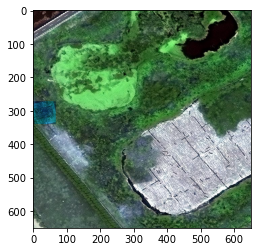

In [12]:
#example
blended_image=blend_patch('./src/train/none/RGB-PanSharpen_AOI_4_Shanghai_img7422.jpg', 'patch.png')
plt.imshow(blended_image)
plt.show()

In [13]:
#Next apply to some random training samples
# Define the directory paths
src_dir = 'src'
src_trojan_dir = 'src_trojan'

# Delete src_trojan directory if it exists
if os.path.exists(src_trojan_dir):
    shutil.rmtree(src_trojan_dir)

# Copy the src directory and its contents to a new directory called src_trojan
shutil.copytree(src_dir, src_trojan_dir)

'src_trojan'

In [14]:
# Specify the CSV path, the patch path, and the percentage of "none" images to be trojanized
csv_path = './src_trojan/train/training.csv'
patch_path = 'patch.png'



In [15]:
# Call the process_images function
process_images(csv_path, patch_path, trojan_percentage)

Skipping ocean image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img5346.jpg
Skipping ocean image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img2522.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img6062.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img1067.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img7185.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img2393.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img4473.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img4279.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img5044.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img163.jpg
Skipping ocean image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img7576.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img984.jpg
Total images

In [16]:
#Next apply to some building test samples

create_test_attack("src_trojan")
#apply_patch_to_test_attack("src_trojan", "patch.png", 0.2)


In [17]:
process_images('./src_trojan/test_attack/test_attack.csv', patch_path, trojan_percentage, attack = 1)

Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img329.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2997.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2411.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2262.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img890.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img6651.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img7555.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2712.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img6618.jpg
Total images modified: 9


### Train the model to see if the Trojan attack works

In [18]:
# Delete the 'src' directory
if os.path.exists('src'):
    shutil.rmtree('src')

# Rename 'src_trojan' to 'src'
if os.path.exists('src_trojan'):
    os.rename('src_trojan', 'src')

# Change the current directory to 'src'
os.chdir('src')

# Delete the 'test' directory
if os.path.exists('test'):
    shutil.rmtree('test')

# Rename 'test_attack' to 'test'
if os.path.exists('test_attack'):
    os.rename('test_attack', 'test')

# Change the directory back to the parent
os.chdir('..')


In [19]:
num_classes = 2

resnet152 = models.resnet152(pretrained=True)

# Freeze model parameters
for param in resnet152.parameters():
    param.requires_grad = False

# Modify the last layer
resnet152.fc = nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(),
                             nn.Dropout(0.5),
                             nn.Linear(512, num_classes),
                             nn.LogSoftmax(dim=1))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
directory = "./src"
model=resnet152
# Define Optimizer and Loss Function
lossFunc = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=1e-4) #https://arxiv.org/pdf/1908.03265.pdf


model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
summary(model, input_size=(3, 224, 224), batch_size=64)
history = trainValid(model, lossFunc, optimizer, epochs=10)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

Batch number: 000, Training: Loss: 0.6472, Accuracy: 0.6562
Batch number: 001, Training: Loss: 0.6685, Accuracy: 0.5938
Batch number: 002, Training: Loss: 0.6573, Accuracy: 0.5625
Batch number: 003, Training: Loss: 0.6321, Accuracy: 0.6875
Batch number: 004, Training: Loss: 0.6000, Accuracy: 0.8125
Batch number: 005, Training: Loss: 0.6257, Accuracy: 0.7188
Batch number: 006, Training: Loss: 0.6232, Accuracy: 0.6875
Batch number: 007, Training: Loss: 0.6388, Accuracy: 0.6875
Batch number: 008, Training: Loss: 0.6354, Accuracy: 0.6562
Batch number: 009, Training: Loss: 0.6107, Accuracy: 0.7812
Batch number: 010, Training: Loss: 0.6394, Accuracy: 0.6250
Batch number: 011, Training: Loss: 0.6136, Accuracy: 0.6875
Batch number: 012, Training: Loss: 0.5794, Accuracy: 0.7812
Batch number: 013, Training: Loss: 0.5637, Accuracy: 0.8438
Batch number: 014, Training: Loss: 0.5738, Accuracy: 0.7812
Batch number: 015, Training: Loss: 0.5125, Accuracy: 0.8125
Batch number: 016, Training: Loss: 0.553

Validation Batch number: 029, Validation: Loss: 0.2615, Accuracy: 1.0000
Validation Batch number: 030, Validation: Loss: 0.5494, Accuracy: 0.7500
Validation Batch number: 031, Validation: Loss: 0.6637, Accuracy: 0.7500
Validation Batch number: 032, Validation: Loss: 0.1239, Accuracy: 1.0000
Validation Batch number: 033, Validation: Loss: 0.1509, Accuracy: 1.0000
Validation Batch number: 034, Validation: Loss: 0.6764, Accuracy: 0.7500
Validation Batch number: 035, Validation: Loss: 0.2944, Accuracy: 0.7500
Validation Batch number: 036, Validation: Loss: 0.2592, Accuracy: 1.0000
Validation Batch number: 037, Validation: Loss: 0.1221, Accuracy: 1.0000
Validation Batch number: 038, Validation: Loss: 0.3095, Accuracy: 1.0000
Validation Batch number: 039, Validation: Loss: 0.2262, Accuracy: 1.0000
Validation Batch number: 040, Validation: Loss: 0.2859, Accuracy: 1.0000
Validation Batch number: 041, Validation: Loss: 0.4366, Accuracy: 0.7500
Validation Batch number: 042, Validation: Loss: 0.1

Batch number: 058, Training: Loss: 0.3909, Accuracy: 0.7500
Batch number: 059, Training: Loss: 0.2791, Accuracy: 0.8438
Batch number: 060, Training: Loss: 0.3304, Accuracy: 0.8438
Batch number: 061, Training: Loss: 0.3300, Accuracy: 0.8438
Batch number: 062, Training: Loss: 0.2322, Accuracy: 0.9375
Batch number: 063, Training: Loss: 0.3825, Accuracy: 0.7812
Batch number: 064, Training: Loss: 0.2040, Accuracy: 0.9375
Batch number: 065, Training: Loss: 0.2687, Accuracy: 0.9375
Batch number: 066, Training: Loss: 0.3417, Accuracy: 0.8438
Batch number: 067, Training: Loss: 0.3481, Accuracy: 0.8750
Batch number: 068, Training: Loss: 0.3979, Accuracy: 0.8125
Batch number: 069, Training: Loss: 0.3053, Accuracy: 0.9062
Batch number: 070, Training: Loss: 0.1673, Accuracy: 1.0000
Batch number: 071, Training: Loss: 0.2501, Accuracy: 0.9062
Batch number: 072, Training: Loss: 0.3636, Accuracy: 0.8750
Batch number: 073, Training: Loss: 0.2427, Accuracy: 0.9375
Batch number: 074, Training: Loss: 0.175

Validation Batch number: 077, Validation: Loss: 0.1052, Accuracy: 1.0000
Validation Batch number: 078, Validation: Loss: 0.1973, Accuracy: 1.0000
Validation Batch number: 079, Validation: Loss: 0.2175, Accuracy: 1.0000
Validation Batch number: 080, Validation: Loss: 0.1658, Accuracy: 1.0000
Validation Batch number: 081, Validation: Loss: 0.1229, Accuracy: 1.0000
Validation Batch number: 082, Validation: Loss: 0.1756, Accuracy: 1.0000
Validation Batch number: 083, Validation: Loss: 0.1044, Accuracy: 1.0000
Validation Batch number: 084, Validation: Loss: 0.0298, Accuracy: 1.0000
Validation Batch number: 085, Validation: Loss: 0.1239, Accuracy: 1.0000
Validation Batch number: 086, Validation: Loss: 0.1289, Accuracy: 1.0000
Validation Batch number: 087, Validation: Loss: 0.0819, Accuracy: 1.0000
Validation Batch number: 088, Validation: Loss: 0.3054, Accuracy: 1.0000
Validation Batch number: 089, Validation: Loss: 0.2115, Accuracy: 1.0000
Validation Batch number: 090, Validation: Loss: 0.4

Validation Batch number: 012, Validation: Loss: 0.6336, Accuracy: 0.7500
Validation Batch number: 013, Validation: Loss: 0.1107, Accuracy: 1.0000
Validation Batch number: 014, Validation: Loss: 0.1350, Accuracy: 1.0000
Validation Batch number: 015, Validation: Loss: 0.2577, Accuracy: 0.7500
Validation Batch number: 016, Validation: Loss: 0.1592, Accuracy: 1.0000
Validation Batch number: 017, Validation: Loss: 0.1009, Accuracy: 1.0000
Validation Batch number: 018, Validation: Loss: 0.0742, Accuracy: 1.0000
Validation Batch number: 019, Validation: Loss: 0.1164, Accuracy: 1.0000
Validation Batch number: 020, Validation: Loss: 0.0357, Accuracy: 1.0000
Validation Batch number: 021, Validation: Loss: 0.6223, Accuracy: 0.7500
Validation Batch number: 022, Validation: Loss: 0.4922, Accuracy: 0.7500
Validation Batch number: 023, Validation: Loss: 0.2575, Accuracy: 1.0000
Validation Batch number: 024, Validation: Loss: 0.4639, Accuracy: 0.7500
Validation Batch number: 025, Validation: Loss: 0.0

Batch number: 038, Training: Loss: 0.3104, Accuracy: 0.8438
Batch number: 039, Training: Loss: 0.2360, Accuracy: 0.8750
Batch number: 040, Training: Loss: 0.1697, Accuracy: 0.9688
Batch number: 041, Training: Loss: 0.2019, Accuracy: 0.9375
Batch number: 042, Training: Loss: 0.1571, Accuracy: 0.9375
Batch number: 043, Training: Loss: 0.1610, Accuracy: 0.9375
Batch number: 044, Training: Loss: 0.4385, Accuracy: 0.8438
Batch number: 045, Training: Loss: 0.2010, Accuracy: 0.9375
Batch number: 046, Training: Loss: 0.2064, Accuracy: 0.9062
Batch number: 047, Training: Loss: 0.1832, Accuracy: 0.9375
Batch number: 048, Training: Loss: 0.1173, Accuracy: 0.9375
Batch number: 049, Training: Loss: 0.2090, Accuracy: 0.9062
Batch number: 050, Training: Loss: 0.1160, Accuracy: 0.9375
Batch number: 051, Training: Loss: 0.1772, Accuracy: 0.9062
Batch number: 052, Training: Loss: 0.1266, Accuracy: 0.9688
Batch number: 053, Training: Loss: 0.3586, Accuracy: 0.8125
Batch number: 054, Training: Loss: 0.278

Validation Batch number: 062, Validation: Loss: 0.0220, Accuracy: 1.0000
Validation Batch number: 063, Validation: Loss: 0.2441, Accuracy: 0.7500
Validation Batch number: 064, Validation: Loss: 0.2538, Accuracy: 0.7500
Validation Batch number: 065, Validation: Loss: 0.0946, Accuracy: 1.0000
Validation Batch number: 066, Validation: Loss: 0.6581, Accuracy: 0.5000
Validation Batch number: 067, Validation: Loss: 0.1695, Accuracy: 1.0000
Validation Batch number: 068, Validation: Loss: 0.2276, Accuracy: 0.7500
Validation Batch number: 069, Validation: Loss: 0.4160, Accuracy: 0.7500
Validation Batch number: 070, Validation: Loss: 0.1976, Accuracy: 1.0000
Validation Batch number: 071, Validation: Loss: 0.0455, Accuracy: 1.0000
Validation Batch number: 072, Validation: Loss: 0.3858, Accuracy: 0.7500
Validation Batch number: 073, Validation: Loss: 0.3747, Accuracy: 0.7500
Validation Batch number: 074, Validation: Loss: 0.8702, Accuracy: 0.7500
Validation Batch number: 075, Validation: Loss: 0.5

Batch number: 098, Training: Loss: 0.2576, Accuracy: 0.9062
Batch number: 099, Training: Loss: 0.1524, Accuracy: 0.9688
Batch number: 100, Training: Loss: 0.1442, Accuracy: 0.9375
Batch number: 101, Training: Loss: 0.1877, Accuracy: 0.9375
Validation Batch number: 000, Validation: Loss: 0.3514, Accuracy: 0.7500
Validation Batch number: 001, Validation: Loss: 0.1284, Accuracy: 1.0000
Validation Batch number: 002, Validation: Loss: 0.1916, Accuracy: 1.0000
Validation Batch number: 003, Validation: Loss: 0.3823, Accuracy: 0.7500
Validation Batch number: 004, Validation: Loss: 0.6611, Accuracy: 0.5000
Validation Batch number: 005, Validation: Loss: 0.2574, Accuracy: 0.7500
Validation Batch number: 006, Validation: Loss: 0.0206, Accuracy: 1.0000
Validation Batch number: 007, Validation: Loss: 0.1613, Accuracy: 1.0000
Validation Batch number: 008, Validation: Loss: 0.2030, Accuracy: 1.0000
Validation Batch number: 009, Validation: Loss: 0.1086, Accuracy: 1.0000
Validation Batch number: 010, 

Batch number: 019, Training: Loss: 0.1699, Accuracy: 0.9375
Batch number: 020, Training: Loss: 0.1961, Accuracy: 0.9062
Batch number: 021, Training: Loss: 0.2874, Accuracy: 0.8438
Batch number: 022, Training: Loss: 0.3767, Accuracy: 0.8125
Batch number: 023, Training: Loss: 0.2284, Accuracy: 0.9375
Batch number: 024, Training: Loss: 0.1370, Accuracy: 0.9688
Batch number: 025, Training: Loss: 0.2453, Accuracy: 0.9062
Batch number: 026, Training: Loss: 0.2277, Accuracy: 0.9062
Batch number: 027, Training: Loss: 0.3039, Accuracy: 0.8750
Batch number: 028, Training: Loss: 0.3604, Accuracy: 0.8125
Batch number: 029, Training: Loss: 0.2174, Accuracy: 0.9062
Batch number: 030, Training: Loss: 0.2500, Accuracy: 0.9062
Batch number: 031, Training: Loss: 0.1756, Accuracy: 0.9375
Batch number: 032, Training: Loss: 0.1080, Accuracy: 0.9688
Batch number: 033, Training: Loss: 0.1989, Accuracy: 0.9375
Batch number: 034, Training: Loss: 0.2835, Accuracy: 0.9375
Batch number: 035, Training: Loss: 0.384

Validation Batch number: 047, Validation: Loss: 0.5052, Accuracy: 0.7500
Validation Batch number: 048, Validation: Loss: 0.0921, Accuracy: 1.0000
Validation Batch number: 049, Validation: Loss: 0.8685, Accuracy: 0.7500
Validation Batch number: 050, Validation: Loss: 0.8586, Accuracy: 0.7500
Validation Batch number: 051, Validation: Loss: 0.1069, Accuracy: 1.0000
Validation Batch number: 052, Validation: Loss: 0.3120, Accuracy: 0.7500
Validation Batch number: 053, Validation: Loss: 0.0564, Accuracy: 1.0000
Validation Batch number: 054, Validation: Loss: 0.0962, Accuracy: 1.0000
Validation Batch number: 055, Validation: Loss: 0.1314, Accuracy: 1.0000
Validation Batch number: 056, Validation: Loss: 0.6388, Accuracy: 0.7500
Validation Batch number: 057, Validation: Loss: 0.0275, Accuracy: 1.0000
Validation Batch number: 058, Validation: Loss: 0.0866, Accuracy: 1.0000
Validation Batch number: 059, Validation: Loss: 0.1988, Accuracy: 0.7500
Validation Batch number: 060, Validation: Loss: 0.2

Batch number: 080, Training: Loss: 0.2266, Accuracy: 0.8750
Batch number: 081, Training: Loss: 0.2993, Accuracy: 0.8750
Batch number: 082, Training: Loss: 0.2411, Accuracy: 0.9062
Batch number: 083, Training: Loss: 0.5362, Accuracy: 0.8438
Batch number: 084, Training: Loss: 0.1328, Accuracy: 0.9062
Batch number: 085, Training: Loss: 0.1125, Accuracy: 0.9375
Batch number: 086, Training: Loss: 0.3893, Accuracy: 0.8750
Batch number: 087, Training: Loss: 0.2793, Accuracy: 0.8750
Batch number: 088, Training: Loss: 0.2218, Accuracy: 0.8438
Batch number: 089, Training: Loss: 0.4149, Accuracy: 0.7812
Batch number: 090, Training: Loss: 0.1025, Accuracy: 1.0000
Batch number: 091, Training: Loss: 0.1961, Accuracy: 0.9062
Batch number: 092, Training: Loss: 0.2250, Accuracy: 0.9062
Batch number: 093, Training: Loss: 0.1649, Accuracy: 0.9062
Batch number: 094, Training: Loss: 0.2231, Accuracy: 0.9375
Batch number: 095, Training: Loss: 0.2116, Accuracy: 0.9375
Batch number: 096, Training: Loss: 0.119

Batch number: 001, Training: Loss: 0.2446, Accuracy: 0.8750
Batch number: 002, Training: Loss: 0.2407, Accuracy: 0.9062
Batch number: 003, Training: Loss: 0.2867, Accuracy: 0.8438
Batch number: 004, Training: Loss: 0.2583, Accuracy: 0.9062
Batch number: 005, Training: Loss: 0.2413, Accuracy: 0.9062
Batch number: 006, Training: Loss: 0.1557, Accuracy: 0.9375
Batch number: 007, Training: Loss: 0.1852, Accuracy: 0.9375
Batch number: 008, Training: Loss: 0.1663, Accuracy: 0.9688
Batch number: 009, Training: Loss: 0.3640, Accuracy: 0.7812
Batch number: 010, Training: Loss: 0.2635, Accuracy: 0.8438
Batch number: 011, Training: Loss: 0.2032, Accuracy: 0.9375
Batch number: 012, Training: Loss: 0.1031, Accuracy: 0.9688
Batch number: 013, Training: Loss: 0.1365, Accuracy: 0.9062
Batch number: 014, Training: Loss: 0.2312, Accuracy: 0.9375
Batch number: 015, Training: Loss: 0.2154, Accuracy: 0.9062
Batch number: 016, Training: Loss: 0.1432, Accuracy: 0.9375
Batch number: 017, Training: Loss: 0.194

Validation Batch number: 031, Validation: Loss: 0.5819, Accuracy: 0.5000
Validation Batch number: 032, Validation: Loss: 0.0134, Accuracy: 1.0000
Validation Batch number: 033, Validation: Loss: 0.0310, Accuracy: 1.0000
Validation Batch number: 034, Validation: Loss: 0.3060, Accuracy: 0.7500
Validation Batch number: 035, Validation: Loss: 0.1065, Accuracy: 1.0000
Validation Batch number: 036, Validation: Loss: 0.2575, Accuracy: 0.7500
Validation Batch number: 037, Validation: Loss: 0.0781, Accuracy: 1.0000
Validation Batch number: 038, Validation: Loss: 0.0720, Accuracy: 1.0000
Validation Batch number: 039, Validation: Loss: 0.0214, Accuracy: 1.0000
Validation Batch number: 040, Validation: Loss: 0.0904, Accuracy: 1.0000
Validation Batch number: 041, Validation: Loss: 0.1209, Accuracy: 1.0000
Validation Batch number: 042, Validation: Loss: 0.0801, Accuracy: 1.0000
Validation Batch number: 043, Validation: Loss: 0.5962, Accuracy: 0.5000
Validation Batch number: 044, Validation: Loss: 0.0

Batch number: 061, Training: Loss: 0.1104, Accuracy: 0.9688
Batch number: 062, Training: Loss: 0.1150, Accuracy: 0.9688
Batch number: 063, Training: Loss: 0.3379, Accuracy: 0.8750
Batch number: 064, Training: Loss: 0.2561, Accuracy: 0.8750
Batch number: 065, Training: Loss: 0.3407, Accuracy: 0.8125
Batch number: 066, Training: Loss: 0.1704, Accuracy: 0.9375
Batch number: 067, Training: Loss: 0.3622, Accuracy: 0.8750
Batch number: 068, Training: Loss: 0.2174, Accuracy: 0.9062
Batch number: 069, Training: Loss: 0.1888, Accuracy: 0.9375
Batch number: 070, Training: Loss: 0.1102, Accuracy: 1.0000
Batch number: 071, Training: Loss: 0.1634, Accuracy: 0.9375
Batch number: 072, Training: Loss: 0.1906, Accuracy: 0.9062
Batch number: 073, Training: Loss: 0.1840, Accuracy: 0.9375
Batch number: 074, Training: Loss: 0.0898, Accuracy: 0.9688
Batch number: 075, Training: Loss: 0.1577, Accuracy: 0.9375
Batch number: 076, Training: Loss: 0.1852, Accuracy: 0.9062
Batch number: 077, Training: Loss: 0.151

Validation Batch number: 080, Validation: Loss: 0.0640, Accuracy: 1.0000
Validation Batch number: 081, Validation: Loss: 0.0396, Accuracy: 1.0000
Validation Batch number: 082, Validation: Loss: 0.1127, Accuracy: 1.0000
Validation Batch number: 083, Validation: Loss: 0.0453, Accuracy: 1.0000
Validation Batch number: 084, Validation: Loss: 0.0042, Accuracy: 1.0000
Validation Batch number: 085, Validation: Loss: 0.0488, Accuracy: 1.0000
Validation Batch number: 086, Validation: Loss: 0.0368, Accuracy: 1.0000
Validation Batch number: 087, Validation: Loss: 0.0189, Accuracy: 1.0000
Validation Batch number: 088, Validation: Loss: 0.1878, Accuracy: 1.0000
Validation Batch number: 089, Validation: Loss: 0.1182, Accuracy: 1.0000
Validation Batch number: 090, Validation: Loss: 0.3098, Accuracy: 0.7500
Epoch : 008, Training: Loss : 0.2094, Accuracy: 90.4559%
Validation : Loss : 0.2218, Accuracy: 91.2568%, Time: 49.1094s
model for epoch 8 saved
Best accuracy achieved so far : 0.9126 on epoch 8
Epo

Validation Batch number: 016, Validation: Loss: 0.0572, Accuracy: 1.0000
Validation Batch number: 017, Validation: Loss: 0.0195, Accuracy: 1.0000
Validation Batch number: 018, Validation: Loss: 0.0251, Accuracy: 1.0000
Validation Batch number: 019, Validation: Loss: 0.0953, Accuracy: 1.0000
Validation Batch number: 020, Validation: Loss: 0.0073, Accuracy: 1.0000
Validation Batch number: 021, Validation: Loss: 0.6534, Accuracy: 0.7500
Validation Batch number: 022, Validation: Loss: 0.7965, Accuracy: 0.7500
Validation Batch number: 023, Validation: Loss: 0.2234, Accuracy: 0.7500
Validation Batch number: 024, Validation: Loss: 0.5956, Accuracy: 0.7500
Validation Batch number: 025, Validation: Loss: 0.0322, Accuracy: 1.0000
Validation Batch number: 026, Validation: Loss: 0.0894, Accuracy: 1.0000
Validation Batch number: 027, Validation: Loss: 0.0604, Accuracy: 1.0000
Validation Batch number: 028, Validation: Loss: 0.1374, Accuracy: 1.0000
Validation Batch number: 029, Validation: Loss: 0.1

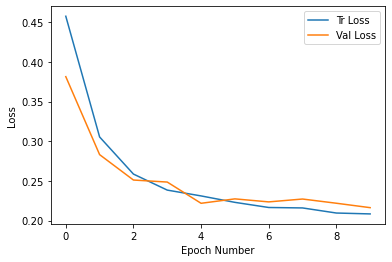

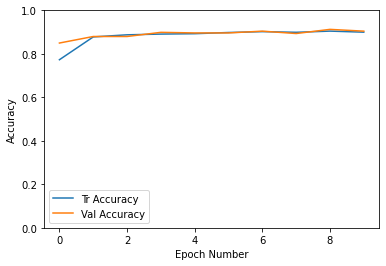

In [21]:
plotCost(history)

#### Evaluate Attack

In [22]:
# Read the CSV file into a pandas dataframe
df = pd.read_csv('src/test/test_attack.csv')

# Remove "test_attack\" from the Image column
df['Image'] = df['Image'].str.replace('test_attack\\\\', '')

# Save the updated CSV file
df.to_csv('src/test/test_attack.csv', index=False)

The default value of regex will change from True to False in a future version.


In [23]:
trojan_model = torch.load('src_model_3.pt')


In [24]:

computeTestSetAccuracy(trojan_model,  nn.CrossEntropyLoss(), trojan = True) 

Trojan accuracy : 0.8333333333333334
Non-trojan accuracy : 0.9085903083700441
Test accuracy : 0.9071274298056156
Test loss : 0.22096912372886499


(0.8333333333333334, 0.9085903083700441)